## Fraud Consumer metric


In [72]:
import pandas as pd
import numpy as np
import os
import re

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

# Regression

In [73]:
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")
transaction_sdf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_sdf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_sdf3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_sdf1.union(transaction_sdf2).union(transaction_sdf3)

In [74]:
transaction_sdf1.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



### plot on transaction 1

In [75]:
from pyspark.sql import functions as F

consumer_agg_daily_sdf1 = transaction_sdf1.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('total_amount'),
    F.countDistinct(F.col('order_id')).alias("total_order")
)

consumer_fraud_join_df1 = consumer_agg_daily_sdf1.join(consumer_fraud_sdf,on=["user_id","order_datetime"]).toPandas()

Text(0.5, 1.0, 'total_amount vs fraud_probability')

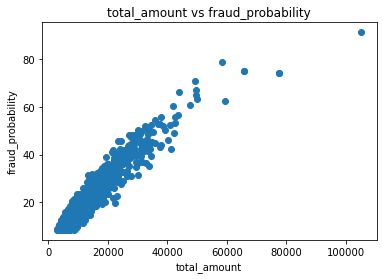

In [76]:
import matplotlib.pyplot as plt
plt.scatter(x=consumer_fraud_join_df1["total_amount"],y=consumer_fraud_join_df1["fraud_probability"])
plt.xlabel('total_amount')
plt.ylabel('fraud_probability') 
plt.title('total_amount vs fraud_probability')


Text(0.5, 1.0, 'total_order vs fraud_probability')

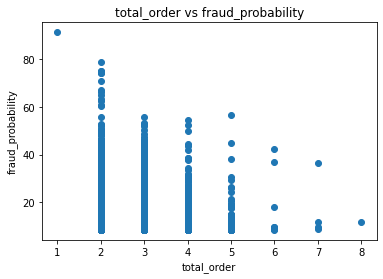

In [77]:
plt.scatter(x=consumer_fraud_join_df1["total_order"],y=consumer_fraud_join_df1["fraud_probability"])
plt.xlabel('total_order')
plt.ylabel('fraud_probability') 
plt.title('total_order vs fraud_probability')

### plot on transaction 2

In [78]:
consumer_agg_daily_sdf2 = transaction_sdf2.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('total_amount'),
    F.countDistinct(F.col('order_id')).alias("total_order")
)

consumer_fraud_join_df2 = consumer_agg_daily_sdf2.join(consumer_fraud_sdf,on=["user_id","order_datetime"]).toPandas()

Text(0.5, 1.0, 'consumer_spending vs fraud_probability')

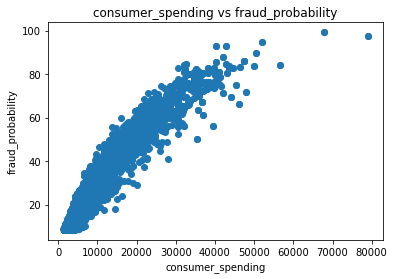

In [101]:
plt.scatter(x=consumer_fraud_join_df2["total_amount"],y=consumer_fraud_join_df2["fraud_probability"])
plt.xlabel('consumer_spending')
plt.ylabel('fraud_probability') 
plt.title('consumer_spending vs fraud_probability')

In [93]:
plt.scatter(x=consumer_fraud_join_df2["total_order"],y=consumer_fraud_join_df2["fraud_probability"])
plt.xlabel('total_order')
plt.ylabel('fraud_probability') 
plt.title('total_order vs fraud_probability')
plt.close()

ValueError: Must be a marker for each trace level

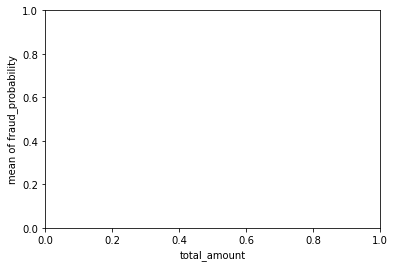

In [106]:
#plt.scatter(x=consumer_fraud_join_df2["total_amount"]/consumer_fraud_join_df2["total_order"],y=consumer_fraud_join_df2["fraud_probability"])



from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(consumer_fraud_join_df2["total_amount"],consumer_fraud_join_df2["total_order"],consumer_fraud_join_df2["fraud_probability"],colors=['black','gray'], markers=['*', 'o'], ylabel='fraud_probability', xlabel='total_amount')
plt.show()

## check distribution of normal transaction

In [81]:
consumer_agg_daily_df1 = consumer_agg_daily_sdf1.toPandas()

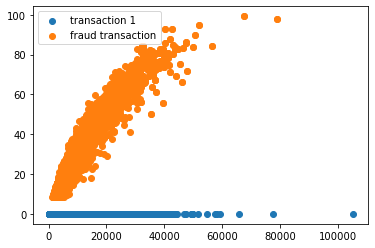

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=consumer_agg_daily_df1['total_amount'], y=[0]*consumer_agg_daily_df1['total_amount'].count(),label="transaction 1")
ax1.scatter(x=consumer_fraud_join_df2["total_amount"],y=consumer_fraud_join_df2["fraud_probability"],label="fraud transaction")
plt.legend(loc='upper left')
plt.show()

# plt.scatter(x=consumer_agg_daily_df1['total_amount'], y=[np.mean(consumer_agg_daily_df1['total_amount'])]*consumer_agg_daily_df1['total_amount'].count())

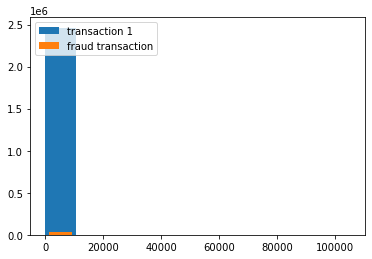

In [83]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.hist(x=consumer_agg_daily_df1['total_amount'],label="transaction 1")
ax1.hist(x=consumer_fraud_join_df2["total_amount"],label="fraud transaction")
plt.legend(loc='upper left')
plt.show()

# Regression on fraud probability

In [84]:
from statsmodels.formula.api import ols, glm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

consumer_fraud_join_df_1_2 = consumer_fraud_join_df1.append(consumer_fraud_join_df2, ignore_index=True)

fit = ols(
    formula="fraud_probability ~ total_amount + total_order + total_amount/total_order",
    data=consumer_fraud_join_df_1_2
).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      fraud_probability   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 5.208e+04
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:30:13   Log-Likelihood:                -99899.
No. Observations:               34864   AIC:                         1.998e+05
Df Residuals:                   34860   BIC:                         1.998e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/var/folders/vm/4b2l4xh10_71ktbck3tm2plr0000gn/T/ipykernel_93246/3345461682.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  consumer_fraud_join_df_1_2 = consumer_fraud_join_df1.append(consumer_fraud_join_df2, ignore_index=True)


total_order is no longer significant, but the interaction term is.
the interaction term explains why the scatter plot has a log like shape. 
When total amount is the same, less avg dollar value meaning less fraud prob

### Formula: fraud_probability ~ total_amount + total_amount/total_order

## Train model with pyspark model
 consider scalability we will use pyspark module instead


edit: use logistic regression with identity link instead , because our response is 0-1, and the g(response) = response follows a linear trend with our predictors

In [85]:
consumer_agg_daily_train = spark.createDataFrame(consumer_fraud_join_df_1_2).withColumn(
    "avg_dollar_value_per_order",
    F.col("total_amount")/F.col("total_order") # interaction feature added
)

In [86]:
from pyspark.ml.regression import LinearRegression
# from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import Interaction
# consumer_regression = consumer_agg_daily_all[[]].apply(lambda row:join_prob_p_val(row[0],row[1],row[2],row[3],row[4],row[5]),axis=1)
features = 'features'
input_cols = ['total_amount','avg_dollar_value_per_order'] 
# assembler = Interaction()
# assembler.setInputCols(["total_amount", "total_order"])
# assembler.setOutputCol("interaction")
assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(consumer_agg_daily_train.dropna('any'))
# Display the features and targets for our model
model_sdf.select('features').head(5), model_sdf.select('fraud_probability').head(5)



([Row(features=DenseVector([6727.7169, 3363.8585])),
  Row(features=DenseVector([6143.6003, 3071.8001])),
  Row(features=DenseVector([4175.3948, 2087.6974])),
  Row(features=DenseVector([21873.3539, 10936.6769])),
  Row(features=DenseVector([8453.9698, 2113.4924]))],
 [Row(fraud_probability=12.35590520479631),
  Row(fraud_probability=9.613837691105958),
  Row(fraud_probability=8.707459655061616),
  Row(fraud_probability=35.081845582853106),
  Row(fraud_probability=16.34958640412933)])

In [87]:
lm = LinearRegression(
    featuresCol='features', 
    labelCol='fraud_probability',
    maxIter=1000
).fit(model_sdf)

# glm = GeneralizedLinearRegression(
#     family="binomial", 
#     link="identity",
#     predictionCol='prediction',
#     labelCol='fraud_probability',
# ).fit(model_sdf)


In [88]:
# print(lm.coefficients)
# print(lm.intercept)
# coefficient is different, investigate

In [89]:
# save model

model_path = "../models" + "/lr_model"
lm.save(model_path)


Py4JJavaError: An error occurred while calling o1302.save.
: java.io.IOException: Path ../models/lr_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)


## apply the pyspark model to all data

In [ ]:
consumer_agg_daily_all = transaction.groupBy(["user_id","order_datetime"]).agg(
    F.sum(F.col('dollar_value')).alias('total_amount'),
    F.countDistinct(F.col('order_id')).alias("total_order")
).withColumn(
    "avg_dollar_value_per_order",
    F.col("total_amount")/F.col("total_order") # interaction feature added
)
#consumer_agg_daily_all.count() # 9 mil data


In [ ]:
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler
model_path = "../models" + "/lr_model"
lm = LinearRegressionModel.load(model_path)
features = 'features'
input_cols = ['total_amount','avg_dollar_value_per_order'] 
# assembler = Interaction()
# assembler.setInputCols(["total_amount", "total_order"])
# assembler.setOutputCol("interaction")
assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

predict_sdf = assembler.transform(consumer_agg_daily_all).select(features)
result_sdf = lm.transform(predict_sdf)


Row(features=DenseVector([8.7082, 8.7082]), prediction=5.973959006808364)

In [ ]:
from pyspark.sql.types import StructType, StructField, LongType

def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

df1_ci = with_column_index(consumer_agg_daily_all)
df2_ci = with_column_index(result_sdf)


user_datetime_predict_sdf = df1_ci.join(df2_ci, df1_ci.ColumnIndex == df2_ci.ColumnIndex, 'inner').drop("ColumnIndex")


#user_datetime_predict_sdf = consumer_agg_daily_all.join(result_sdf.select(["prediction","columnindex"]),on="columnindex")
user_datetime_predict_sdf= user_datetime_predict_sdf.withColumnRenamed(
    "prediction",
    "fraud_prob"
)

## 

## calculate the discounted revenue

In [ ]:
from pyspark.sql.functions import udf, array
from pyspark.sql.types import FloatType
THRESHHOLD = lm.intercept

def calculate_discounted_revenue(rate):
    if rate < THRESHHOLD:
        return 1
    elif rate > 100:
        return 0
    else: 
        return 1-(rate*0.01)
       
# sdf = sdf.withColumn(
#     'transformed_col',
#     some_udf(F.col('raw_col'))
# )
convert_rate = udf(lambda z: calculate_discounted_revenue(z),FloatType())

In [ ]:
# run slice by slice
transaction_slices = [transaction_sdf1,transaction_sdf2,transaction_sdf3]

for i in range(3):
    merchant_user_agg_sdf = transaction_slices[i].groupBy(["merchant_abn","order_datetime","user_id"]).agg(
        F.countDistinct(F.col("order_id")).alias("no_order"),
        F.sum(F.col("dollar_value")).alias("dollar_amount")
    )



    user_discounted_spending_sdf = merchant_user_agg_sdf \
        .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
        .withColumn(
            "convert_rate",
            convert_rate(F.col("fraud_prob"))
        ).withColumn(
            "discounted_spending",
            F.col("convert_rate") * F.col("dollar_amount")
        )

    merchant_discounted_daily_revenue = user_discounted_spending_sdf.groupBy(["merchant_abn","order_datetime"]).agg(
        F.sum(F.col("discounted_spending")).alias("discounted_daily_revenue")
    )

    merchant_discounted_daily_revenue.write.mode('overwrite').parquet(f'../data/curated/merchant_discounted_daily_revenue_slice_{i}.parquet')


### debug (dont need to put into the script)

In [ ]:
df = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_0.parquet")
test = df.sample(False, 0.1, seed=0).limit(1000).toPandas()

(array([826., 111.,  24.,   9.,  13.,   7.,   6.,   2.,   1.,   1.]),
 array([1.53813504e+00, 2.00202436e+03, 4.00251059e+03, 6.00299682e+03,
        8.00348304e+03, 1.00039693e+04, 1.20044555e+04, 1.40049417e+04,
        1.60054279e+04, 1.80059142e+04, 2.00064004e+04]),
 <BarContainer object of 10 artists>)

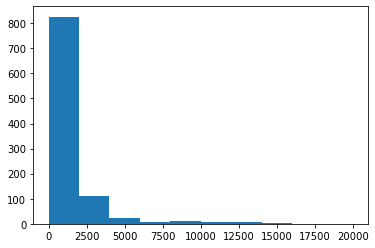

In [ ]:
import matplotlib.pyplot as plt
plt.hist(test["discounted_daily_revenue"])

In [ ]:
test = merchant_discounted_daily_revenue.where(
    F.col("discounted_daily_revenue")<0
)
############
# merchant_user_agg_sdf =transaction_sdf1.groupBy(["merchant_abn","order_datetime","user_id"]).agg(
#     F.countDistinct(F.col("order_id")).alias("no_order"),
#     F.sum(F.col("dollar_value")).alias("dollar_amount")
# )



# test = merchant_user_agg_sdf \
#     .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
#     .withColumn(
#         "convert_rate",
#         convert_rate(F.col("fraud_prob"))
#     )

# test_filter = test.where(
#     F.col("convert_rate") < 0
# )

In [ ]:
test.count()

0

In [ ]:
user_discounted_spending_sdf.head(5)

[Row(user_id=2, order_datetime=datetime.date(2022, 3, 12), merchant_abn=51016899219, no_order=1, dollar_amount=25.92488559459871, fraud_prob=6.09613567658092, convert_rate=0.9390386343002319, discounted_spending=24.344469163141728),
 Row(user_id=2, order_datetime=datetime.date(2022, 3, 12), merchant_abn=28935822912, no_order=1, dollar_amount=50.54855694736198, fraud_prob=6.09613567658092, convert_rate=0.9390386343002319, discounted_spending=47.46704788169829),
 Row(user_id=2, order_datetime=datetime.date(2022, 8, 18), merchant_abn=86578477987, no_order=1, dollar_amount=98.08014557588547, fraud_prob=6.1560513684185665, convert_rate=0.9384394884109497, discounted_spending=92.04228163750543),
 Row(user_id=4, order_datetime=datetime.date(2022, 5, 11), merchant_abn=91720867026, no_order=1, dollar_amount=36.51854801361019, fraud_prob=6.082253951436002, convert_rate=0.9391774535179138, discounted_spending=34.29739692959409),
 Row(user_id=4, order_datetime=datetime.date(2022, 5, 11), merchant_

In [ ]:
#test_filter.count() # 0

0

In [ ]:
#user_datetime_predict_sdf.head()
user_discounted_spending_sdf = merchant_user_agg_sdf \
        .join(user_datetime_predict_sdf.select(["user_id","order_datetime","fraud_prob"]),on=["user_id","order_datetime"]) \
        .withColumn(
            "convert_rate",
            convert_rate(F.col("fraud_prob"))
        )

NameError: name 'merchant_user_agg_sdf' is not defined

In [ ]:
test = user_discounted_spending_sdf.where(
    F.col("convert_rate") < 0
)

In [ ]:
test.head()

In [ ]:
merchant_discounted_daily_revenue = user_discounted_spending_sdf.groupBy(["merchant_abn","order_datetime"]).agg(
    F.sum(F.col("discounted_spending")).alias("discounted_daily_revenue")
)

In [ ]:
merchant_discounted_daily_revenue.printSchema()

In [ ]:
merchant_discounted_daily_revenue.head()

In [ ]:
#merchant_discounted_daily_revenue.head() # cant run

In [ ]:
# from pyspark.sql import functions as F
# slice0 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_0.parquet")
# slice1 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_1.parquet")
# slice3 = spark.read.parquet("../data/curated/merchant_discounted_daily_revenue_slice_2.parquet")

# combine_slices = slice0.union(slice1).union(slice3)

# test = combine_slices.where(
#     F.col("discounted_daily_revenue") < 0
# ).count()

# test

### Remove Fraud data from the transaction set(don't put it into script)
since fraud data is only a small subset of the data, consider remove all transaction entries with fraud probability


In [ ]:
# convert merchant fraud, consumer fraud to spark df
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud_df.to_parquet("../data/temp/merchant_fraud")
merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")

consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud_df.to_parquet("../data/temp/consumer_fraud")
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")

In [ ]:
# save all transaction data to a spark dataframe: transaction
transaction_sdf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_sdf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_sdf3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_sdf1.union(transaction_sdf2).union(transaction_sdf3)

In [ ]:
# find all transaction on merchant fraud day
merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")
merchant_transaction_on_fraud_day = transaction.join(merchant_fraud_sdf.select(["merchant_abn","order_datetime"]), on=["merchant_abn","order_datetime"])

In [ ]:
transaction.printSchema()

In [ ]:
merchant_transaction_on_fraud_day.printSchema()

In [ ]:
# find all transaction on consumer fraud day
consumer_fraud_sdf = spark.read.parquet("../data/temp/consumer_fraud")
consumer_transaction_on_fraud_day = transaction.join(consumer_fraud_sdf.select(["user_id","order_datetime"]), on=["user_id","order_datetime"])

In [ ]:
# filter fraud transactions

order = ["user_id","merchant_abn","dollar_value","order_id","order_datetime"]
transaction_fraud_rm = transaction.subtract(merchant_transaction_on_fraud_day.select(order)).subtract(consumer_transaction_on_fraud_day.select(order))

transaction_fraud_rm can be used for further analysis

### Derive fraud rate and other features

#### Definition:

Merchant Fraud rate: weighted fraud orders / total orders
Fraud 
